<a href="https://colab.research.google.com/github/michaeltm365/projects/blob/main/AllCoinbaseCaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coinbase Take Home Case Study: Michael Murphy

## Library and Data Imports

In [1]:
#@title Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Loading in the data
id_verification = pd.read_csv('/content/drive/MyDrive/2024 Fall/Coinbase DS Intern Take Home Assignment Data (1)/id_verification.csv')
trades = pd.read_csv('/content/drive/MyDrive/2024 Fall/Coinbase DS Intern Take Home Assignment Data (1)/trades.csv')
users = pd.read_csv('/content/drive/MyDrive/2024 Fall/Coinbase DS Intern Take Home Assignment Data (1)/users.csv')

In [3]:
id_verification

,id,user_id,created_at,status,failure_reason
0,00045139,b96f65dd,2023-12-22 10:33:21.373709,success,NaN
1,0008a92e,bb7b0125,2023-01-25 05:49:04.842417,failed,foreign id
2,0008ad08,78e13fd7,2023-05-10 09:09:57.833922,failed,foreign id
3,001dd365,7c205727,2023-04-20 09:56:17.163923,failed,unsupported id type
4,001f5b9b,583a1de0,2023-08-02 02:02:48.588218,success,NaN
...,...,...,...,...,...
9808,ffed2268,700380e0,2023-07-23 07:37:11.603276,failed,unsupported id type
9809,fff27532,ecfa4661,2023-10-11 06:08:54.673223,success,NaN
9810,fff385b1,0a217817,2023-03-16 23:04:53.768142,failed,foreign id
9811,fffb7cda,994ff432,2023-05-28 12:54:27.986766,failed,unsupported id type


In [4]:
trades

,id,user_id,created_at,volume_usd
0,0002d4752b84,e5628fad,2023-12-27 16:38:09.784601,54.247162
1,000635ac8daf,7940eb65,2023-11-16 18:00:26.743051,211.673440
2,0015a7666c9a,2913bfb6,2023-12-09 16:17:05.511726,239.949357
3,001f2a448929,622157d2,2024-06-30 02:35:22.114844,342.818996
4,003af72aaa31,8d7bf4f9,2024-08-23 03:45:26.768765,159.896435
...,...,...,...,...
12386,ffed12a7f1b2,42dd1749,2024-02-26 12:01:39.328753,327.610113
12387,ffeded0a0136,b61b27ee,2023-07-30 20:44:21.130343,43.260796
12388,fff1c884d387,08a097e8,2023-09-07 10:12:53.796142,100.356904
12389,fff84956233c,309004d0,2023-10-23 08:56:14.433214,65.704722


In [5]:
users

,user_id,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at
0,0005dbc9,US,ios,2023-08-27 14:16:00,NaN,NaN,NaN
1,00080e40,US,android,2023-04-27 02:54:00,2023-04-27 02:58:41.103569,2023-04-27 02:55:05.560818,NaN
2,0009a830,CA,ios,2023-10-26 08:42:00,NaN,NaN,NaN
3,00179e0d,US,NaN,2023-08-02 10:20:00,NaN,NaN,NaN
4,001d0f11,US,ios,2023-06-28 23:26:00,2023-06-28 23:31:15.530201,2023-06-28 23:27:44.335701,2023-06-29 17:39:34.863345
...,...,...,...,...,...,...,...
11227,ffe9b6e3,GB,ios,2023-06-22 06:12:00,NaN,NaN,NaN
11228,ffeccd22,GB,ios,2023-02-27 13:22:00,2023-02-27 13:27:02.936281,2023-02-27 13:25:20.506486,NaN
11229,fff7063e,NaN,NaN,2023-08-15 11:42:00,NaN,NaN,NaN
11230,fffc7b36,US,ios,2023-05-10 15:02:00,NaN,NaN,NaN


###Initial observations:

*   Missing values are present in both the id_verification and users table
*   user_id is a primary key for the users table and foreign key for the id_verification tables
*   The trades table has information that is mostly irrelevant to the onboarding process so I probably won't use it much



## EDA Part 1: Adding columns, helper functions, and joining tables

In [6]:
#@title Helper Functions

def get_churning_point(row):
  """
  Determine the latest onboarding step a user reached before churning.

  This function evaluates a user's progress through the onboarding process
  by checking whether key milestones (email, phone, and ID verification)
  have been completed. It identifies the last step they reached but did
  not complete before churning.

  Parameters:
      row (pandas.Series): A single row of the users DataFrame containing
                            the columns "email_verified_at",
                            "phone_verified_at", and "id_verified_at".

  Returns:
      str: The latest incomplete onboarding step, or "completed onboarding"
            if all steps were completed.
  """

  if pd.isnull(row["email_verified_at"]):
    return "email verification"
  if pd.isnull(row["phone_verified_at"]):
    return "phone verification"
  if pd.isnull(row["id_verified_at"]):
    return "id verification"
  else:
    return "completed onboarding"

def get_completion_indicator(row):
  """
  Determine if a user completed the entire onboarding process.

  This function checks whether the "id_verified_at" column contains a
  non-null value, indicating that the user has successfully completed
  all required onboarding steps.

  Parameters:
      row (pandas.Series): A single row of the users DataFrame containing
                            the "id_verified_at" column.

  Returns:
      bool: True if the user completed onboarding (i.e., "id_verified_at"
            is not null), otherwise False.
  """

  return not pd.isnull(row["id_verified_at"])

def t_test(arr1, arr2):
  """
  Perform an independent two-sample t-test to compare the means of two groups.

  This function performs a t-test on two input arrays to determine if the
  difference in their means is statistically significant. It prints whether
  the null hypothesis (no difference) is rejected or not based on a p-value
  threshold of 0.05.

  Parameters:
      arr1 (array-like): The first sample of numeric data.
      arr2 (array-like): The second sample of numeric data.

  Returns:
      float: The p-value from the t-test, indicating the probability of
              observing the difference in means under the null hypothesis.
  """

  t_stat, p_value = ttest_ind(arr1, arr2)
  if p_value < 0.05:
      print("Reject the null hypothesis: The groups are significantly different.")
  else:
      print("Fail to reject the null hypothesis: No significant difference.")
  return p_value

def z_test(bool_arr1, bool_arr2):
  successes = [np.sum(bool_arr1), np.sum(bool_arr2)]
  n_obs = [len(bool_arr1), len(bool_arr2)]

  stat, p_value = proportions_ztest(successes, n_obs)
  if p_value < 0.05:
      print("Reject the null hypothesis: The groups are significantly different.")
  else:
      print("Fail to reject the null hypothesis: No significant difference.")
  return p_value

In [7]:
#@title Applying helper functions to users table
users["churning_point"] = users.apply(get_churning_point, axis = 1)
users["completed"] = users.apply(get_completion_indicator, axis = 1)
users

,user_id,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed
0,0005dbc9,US,ios,2023-08-27 14:16:00,NaN,NaN,NaN,email verification,False
1,00080e40,US,android,2023-04-27 02:54:00,2023-04-27 02:58:41.103569,2023-04-27 02:55:05.560818,NaN,id verification,False
2,0009a830,CA,ios,2023-10-26 08:42:00,NaN,NaN,NaN,email verification,False
3,00179e0d,US,NaN,2023-08-02 10:20:00,NaN,NaN,NaN,email verification,False
4,001d0f11,US,ios,2023-06-28 23:26:00,2023-06-28 23:31:15.530201,2023-06-28 23:27:44.335701,2023-06-29 17:39:34.863345,completed onboarding,True
...,...,...,...,...,...,...,...,...,...
11227,ffe9b6e3,GB,ios,2023-06-22 06:12:00,NaN,NaN,NaN,email verification,False
11228,ffeccd22,GB,ios,2023-02-27 13:22:00,2023-02-27 13:27:02.936281,2023-02-27 13:25:20.506486,NaN,id verification,False
11229,fff7063e,NaN,NaN,2023-08-15 11:42:00,NaN,NaN,NaN,email verification,False
11230,fffc7b36,US,ios,2023-05-10 15:02:00,NaN,NaN,NaN,email verification,False


In [8]:
#@title Merging the id_verification and users tables
id_user_verif = id_verification.merge(users, on = "user_id")
id_user_verif

,id,user_id,created_at,status,failure_reason,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed
0,00045139,b96f65dd,2023-12-22 10:33:21.373709,success,NaN,GB,web,2023-12-20 21:02:00,2023-12-20 21:07:37.41379,2023-12-20 21:04:26.195144,2023-12-22 10:33:21.373709,completed onboarding,True
1,0008a92e,bb7b0125,2023-01-25 05:49:04.842417,failed,foreign id,US,ios,2023-01-24 12:14:00,2023-01-24 12:19:48.28215,2023-01-24 12:17:02.712187,2023-01-25 19:24:55.230361,completed onboarding,True
2,0008ad08,78e13fd7,2023-05-10 09:09:57.833922,failed,foreign id,CA,ios,2023-05-09 12:02:00,2023-05-09 12:06:02.229883,2023-05-09 12:03:38.809155,2023-05-11 14:23:57.987242,completed onboarding,True
3,001dd365,7c205727,2023-04-20 09:56:17.163923,failed,unsupported id type,US,ios,2023-04-20 04:20:00,2023-04-20 04:23:58.315245,2023-04-20 04:21:20.884898,2023-04-22 06:48:04.907614,completed onboarding,True
4,001f5b9b,583a1de0,2023-08-02 02:02:48.588218,success,NaN,CA,android,2023-08-01 21:22:00,2023-08-01 21:27:17.722884,2023-08-01 21:23:35.943513,2023-08-02 02:02:48.588218,completed onboarding,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9808,ffed2268,700380e0,2023-07-23 07:37:11.603276,failed,unsupported id type,US,ios,2023-07-22 11:52:00,2023-07-22 11:58:02.59117,2023-07-22 11:55:20.014094,2023-07-23 16:20:57.891479,completed onboarding,True
9809,fff27532,ecfa4661,2023-10-11 06:08:54.673223,success,NaN,CA,ios,2023-10-11 01:40:00,2023-10-11 01:46:39.41256,2023-10-11 01:43:01.939137,2023-10-11 06:08:54.673223,completed onboarding,True
9810,fff385b1,0a217817,2023-03-16 23:04:53.768142,failed,foreign id,US,ios,2023-03-15 09:40:00,2023-03-15 09:44:00.994532,2023-03-15 09:41:19.750516,NaN,id verification,False
9811,fffb7cda,994ff432,2023-05-28 12:54:27.986766,failed,unsupported id type,US,android,2023-05-28 11:38:00,2023-05-28 11:44:50.220216,2023-05-28 11:40:50.379194,2023-05-28 16:01:38.706133,completed onboarding,True


## EDA Part 2: Determining the order of each verification step

In [9]:
#@title Are there any users who had their email verified but not their phone?
users[(users["phone_verified_at"].isnull()) & ~(users["email_verified_at"].isnull())]

,user_id,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed
51,010c00ee,US,android,2023-01-17 06:26:00,NaN,2023-01-17 06:27:42.11237,NaN,phone verification,False
82,01e17e2b,BR,android,2023-10-21 13:22:00,NaN,2023-10-21 13:24:01.183289,NaN,phone verification,False
94,0249c35e,US,web,2023-07-20 19:12:00,NaN,2023-07-20 19:14:29.151661,NaN,phone verification,False
99,02603e3d,US,ios,2023-10-30 05:20:00,NaN,2023-10-30 05:22:31.891409,NaN,phone verification,False
103,0278e112,BR,android,2023-08-30 12:54:00,NaN,2023-08-30 12:56:06.158202,NaN,phone verification,False
...,...,...,...,...,...,...,...,...,...
11173,fea6f7b0,NaN,web,2023-01-07 19:04:00,NaN,2023-01-07 19:05:56.001363,NaN,phone verification,False
11198,ff3328f3,US,ios,2023-09-01 17:10:00,NaN,2023-09-01 17:12:33.064923,NaN,phone verification,False
11202,ff4898bc,US,android,2023-05-11 06:12:00,NaN,2023-05-11 06:14:03.791954,NaN,phone verification,False
11214,ff995a98,BR,ios,2023-09-20 12:18:00,NaN,2023-09-20 12:20:20.133756,NaN,phone verification,False


In [10]:
#@title Are there any users who had their phone verified but not their email?
users[~(users["phone_verified_at"].isnull()) & (users["email_verified_at"].isnull())]

,user_id,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed


In [11]:
#@title Are there any users who had their id verified but had neither their phone or email verified?
users[~(users["id_verified_at"].isnull()) & (users["phone_verified_at"].isnull()) &
      (users["email_verified_at"].isnull())]

,user_id,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed


In [12]:
#@title Are there any users who had their id verified but had either their phone or email not verified?
users[~(users["id_verified_at"].isnull()) &
      ((users["phone_verified_at"].isnull()) | (users["email_verified_at"].isnull()))]

,user_id,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed


### Conclusion: the order of verification is as follows: email, phone, id. These verifications must be completed in order and none can be skipped.

## Exploration 1: How do churning rates vary across stages of the verification process, countries, and devices?

In [13]:
#@title Defining some useful subsets of data, including users who completed onboarding and users who churned

def completion_rate_category(user_df, cat):
  return user_df.groupby(cat)["completed"].mean()

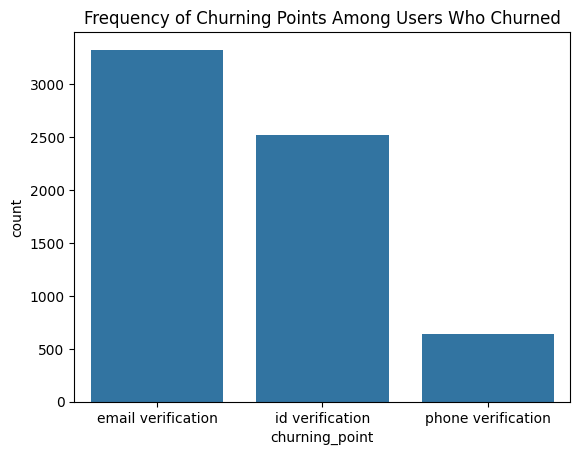

In [14]:
sns.barplot(users[~users["completed"]]["churning_point"].value_counts())
plt.title("Frequency of Churning Points Among Users Who Churned");

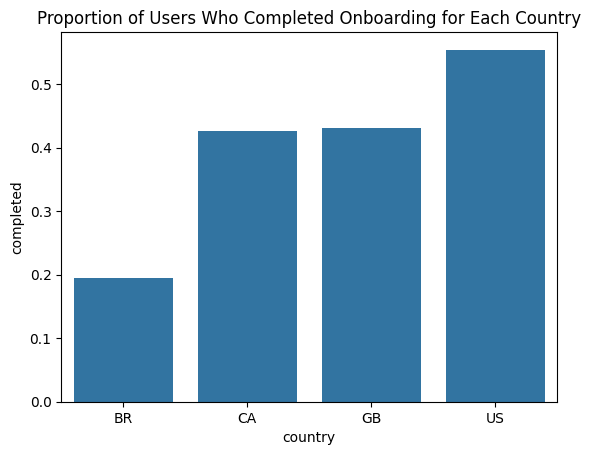

In [15]:
sns.barplot(completion_rate_category(users, "country"))
plt.title("Proportion of Users Who Completed Onboarding for Each Country");

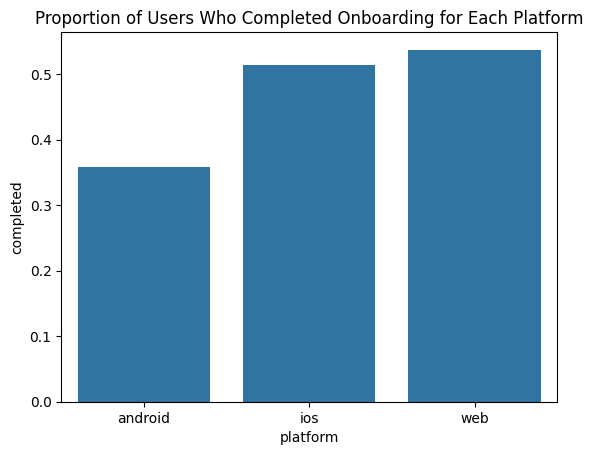

In [16]:
sns.barplot(completion_rate_category(users, "platform"))
plt.title("Proportion of Users Who Completed Onboarding for Each Platform");

### Analysis:
- The majority of users who churn do so before verifying their email
- The proportion of Brazilian users who complete onboarding is significantly lower than the proportions from other countries
- The proportion of android users who complete onboarding is lower than the proportions from other platforms

## Exploration 2: How does the number of failed ID verification attempts affect a user's likelihood to churn?

In [17]:
#@title Getting the number of failed ID verification attempts for each user

# Formula: total attempts - successful attempts

def num_failed_attempts(status_series):
  return len(status_series) - len(status_series[status_series == "success"])

failed_attempts = id_user_verif.groupby("user_id")["status"].agg(
    num_failed_attempts).reset_index().rename(columns = {"status": "failed_attempts"})

failed_attempts

,user_id,failed_attempts
0,001d0f11,0
1,002840e5,0
2,003fdfac,2
3,004c3834,2
4,0052d5d3,2
...,...,...
5677,ffaac7bb,0
5678,ffba54ba,1
5679,ffcc3e2c,0
5680,ffdad8f6,1


In [18]:
#@title Adding failed_attempts for each user to id_user_verif
id_user_verif = id_user_verif.merge(failed_attempts, on = "user_id")
id_user_verif

,id,user_id,created_at,status,failure_reason,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed,failed_attempts
0,00045139,b96f65dd,2023-12-22 10:33:21.373709,success,NaN,GB,web,2023-12-20 21:02:00,2023-12-20 21:07:37.41379,2023-12-20 21:04:26.195144,2023-12-22 10:33:21.373709,completed onboarding,True,2
1,0008a92e,bb7b0125,2023-01-25 05:49:04.842417,failed,foreign id,US,ios,2023-01-24 12:14:00,2023-01-24 12:19:48.28215,2023-01-24 12:17:02.712187,2023-01-25 19:24:55.230361,completed onboarding,True,1
2,0008ad08,78e13fd7,2023-05-10 09:09:57.833922,failed,foreign id,CA,ios,2023-05-09 12:02:00,2023-05-09 12:06:02.229883,2023-05-09 12:03:38.809155,2023-05-11 14:23:57.987242,completed onboarding,True,2
3,001dd365,7c205727,2023-04-20 09:56:17.163923,failed,unsupported id type,US,ios,2023-04-20 04:20:00,2023-04-20 04:23:58.315245,2023-04-20 04:21:20.884898,2023-04-22 06:48:04.907614,completed onboarding,True,3
4,001f5b9b,583a1de0,2023-08-02 02:02:48.588218,success,NaN,CA,android,2023-08-01 21:22:00,2023-08-01 21:27:17.722884,2023-08-01 21:23:35.943513,2023-08-02 02:02:48.588218,completed onboarding,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9808,ffed2268,700380e0,2023-07-23 07:37:11.603276,failed,unsupported id type,US,ios,2023-07-22 11:52:00,2023-07-22 11:58:02.59117,2023-07-22 11:55:20.014094,2023-07-23 16:20:57.891479,completed onboarding,True,1
9809,fff27532,ecfa4661,2023-10-11 06:08:54.673223,success,NaN,CA,ios,2023-10-11 01:40:00,2023-10-11 01:46:39.41256,2023-10-11 01:43:01.939137,2023-10-11 06:08:54.673223,completed onboarding,True,0
9810,fff385b1,0a217817,2023-03-16 23:04:53.768142,failed,foreign id,US,ios,2023-03-15 09:40:00,2023-03-15 09:44:00.994532,2023-03-15 09:41:19.750516,NaN,id verification,False,3
9811,fffb7cda,994ff432,2023-05-28 12:54:27.986766,failed,unsupported id type,US,android,2023-05-28 11:38:00,2023-05-28 11:44:50.220216,2023-05-28 11:40:50.379194,2023-05-28 16:01:38.706133,completed onboarding,True,2


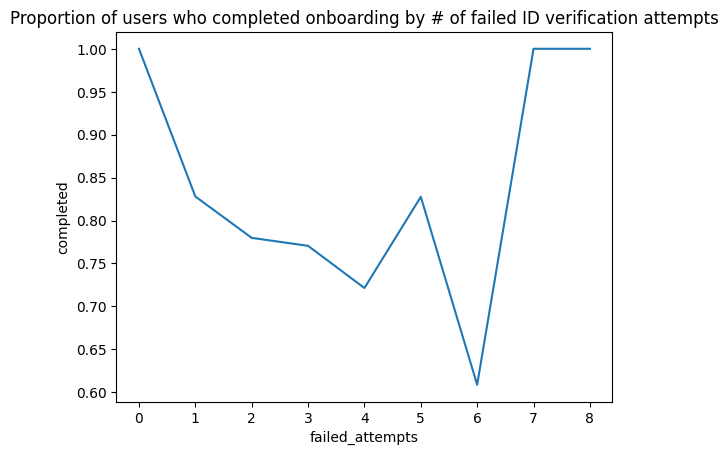

In [19]:
#@title Visualizing

sns.lineplot(id_user_verif.groupby("failed_attempts")["completed"].mean())
plt.title("Proportion of users who completed onboarding by # of failed ID verification attempts");

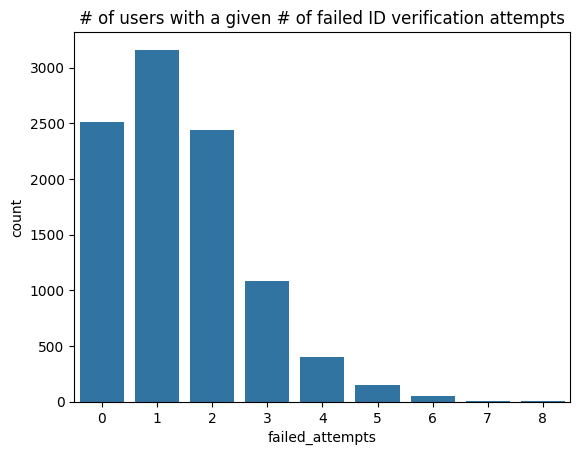

In [20]:
#@title Checking for bias by examining the # of users for each failed_attempts group

sns.barplot(id_user_verif["failed_attempts"].value_counts())
plt.title("# of users with a given # of failed ID verification attempts");

Analysis:
- It is more common for users to fail their first ID verification than to pass it
- After just one failed ID verification attempt, about 82% of users will continue with the onboarding process
- After 6 failed verification attempts, about only 60% of users will continue the onboarding process
- 100% of the users with more than 6 failed verification attempts completed the entire verification process. This could be because these users are extremely motivated to start trading and will do as many verification attempts as necessary, but could be biased by the small number of users who fail this many attempts

## Exploration 3: How do different failure reasons for ID verification attempts affect a user's likelihood to churn?

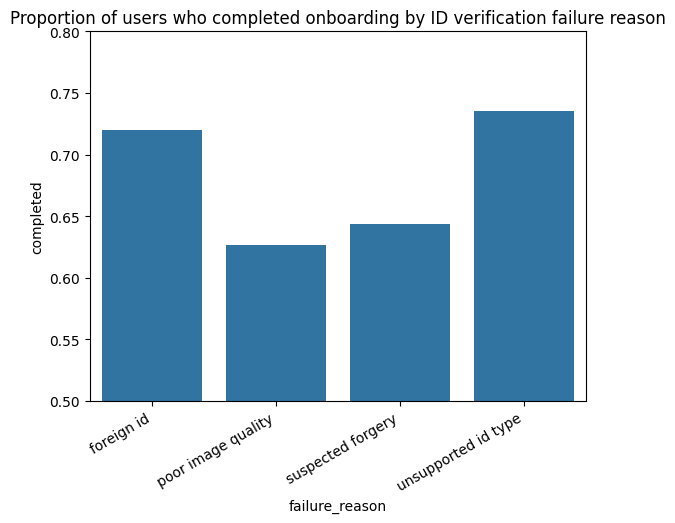

In [21]:
sns.barplot(id_user_verif.groupby("failure_reason")["completed"].mean())
plt.title("Proportion of users who completed onboarding by ID verification failure reason")
plt.ylim(0.5, 0.8)
plt.xticks(rotation=30, ha="right");

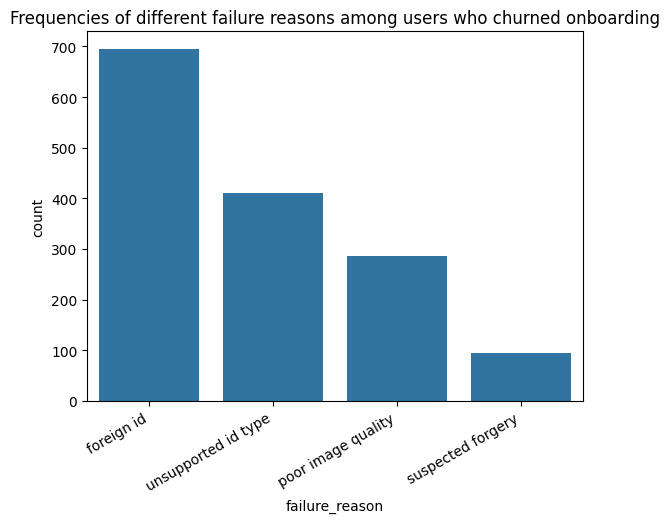

In [22]:
sns.barplot(id_user_verif[~id_user_verif["completed"]]["failure_reason"].value_counts())
plt.title("Frequencies of different failure reasons among users who churned onboarding")
plt.xticks(rotation=30, ha="right");

Analysis:
- None of the failure reasons cause an extreme increase in churning rates relative to the other failure reasons.
- "unsupported id type" had the lowest churning rate. This could suggest that users who receive this failure reason possessed a valid form of ID but were unclear about what IDs were accepted.
- Among users who churned during the ID verification stage, the most common failure reason they received is "foreign id". This could suggest that these users are foreign and this is their only form of verification, and are churning when they find out that it is not accepted

## Exploration 4: Do churning rates vary based on signup time?

In [23]:
#@title Adding various time columns
users["signed_up_at"] = pd.to_datetime(users["signed_up_at"], format='%Y-%m-%d %H:%M:%S', errors='coerce')
users["hour_signed_up_at"] = users["signed_up_at"].dt.hour
users["dow_signed_up_at"] = users["signed_up_at"].dt.day_name()
users["month_year_signed_up_at"] = users["signed_up_at"].dt.strftime('%Y-%m')

for col in ["phone_verified_at", "email_verified_at", "id_verified_at"]:
  users[col] = pd.to_datetime(users[col], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

users

,user_id,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed,hour_signed_up_at,dow_signed_up_at,month_year_signed_up_at
0,0005dbc9,US,ios,2023-08-27 14:16:00,NaT,NaT,NaT,email verification,False,14.0,Sunday,2023-08
1,00080e40,US,android,2023-04-27 02:54:00,2023-04-27 02:58:41.103569,2023-04-27 02:55:05.560818,NaT,id verification,False,2.0,Thursday,2023-04
2,0009a830,CA,ios,2023-10-26 08:42:00,NaT,NaT,NaT,email verification,False,8.0,Thursday,2023-10
3,00179e0d,US,NaN,2023-08-02 10:20:00,NaT,NaT,NaT,email verification,False,10.0,Wednesday,2023-08
4,001d0f11,US,ios,2023-06-28 23:26:00,2023-06-28 23:31:15.530201,2023-06-28 23:27:44.335701,2023-06-29 17:39:34.863345,completed onboarding,True,23.0,Wednesday,2023-06
...,...,...,...,...,...,...,...,...,...,...,...,...
11227,ffe9b6e3,GB,ios,2023-06-22 06:12:00,NaT,NaT,NaT,email verification,False,6.0,Thursday,2023-06
11228,ffeccd22,GB,ios,2023-02-27 13:22:00,2023-02-27 13:27:02.936281,2023-02-27 13:25:20.506486,NaT,id verification,False,13.0,Monday,2023-02
11229,fff7063e,NaN,NaN,2023-08-15 11:42:00,NaT,NaT,NaT,email verification,False,11.0,Tuesday,2023-08
11230,fffc7b36,US,ios,2023-05-10 15:02:00,NaT,NaT,NaT,email verification,False,15.0,Wednesday,2023-05


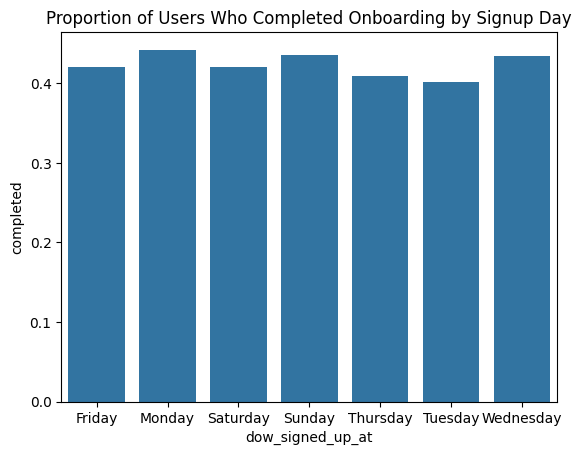

In [24]:
sns.barplot(users.groupby("dow_signed_up_at")["completed"].mean())
plt.title("Proportion of Users Who Completed Onboarding by Signup Day");

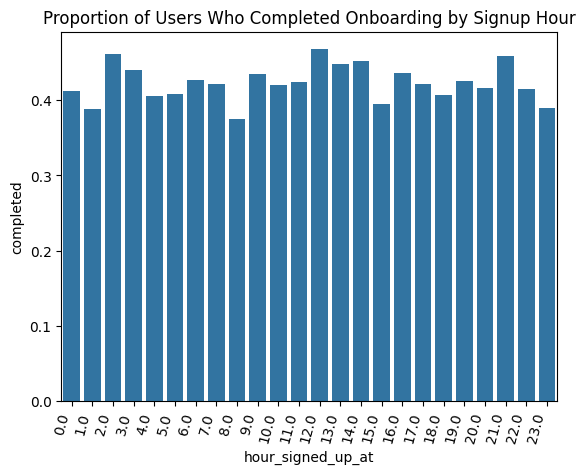

In [25]:
sns.barplot(users.groupby("hour_signed_up_at")["completed"].mean())
plt.title("Proportion of Users Who Completed Onboarding by Signup Hour")
plt.xticks(rotation=75, ha="right");

### Analysis:
- Based off of these visualizations, the day of week and time of day a user signs up at doesn't seem to affect their likelihood to churn
- Potential limitations: time zones, weekday holidays

## Exploration 5: How did the number of signups and churning rate changed throughout 2023?

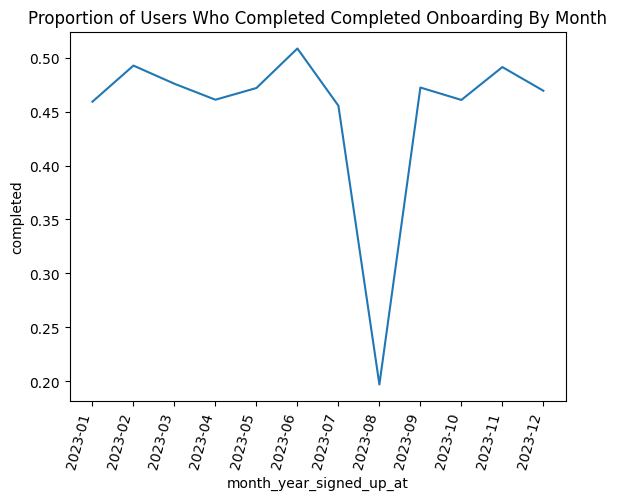

In [26]:
sns.lineplot(users.groupby("month_year_signed_up_at")["completed"].mean())
plt.title("Proportion of Users Who Completed Completed Onboarding By Month")
plt.xticks(rotation=75, ha="right");

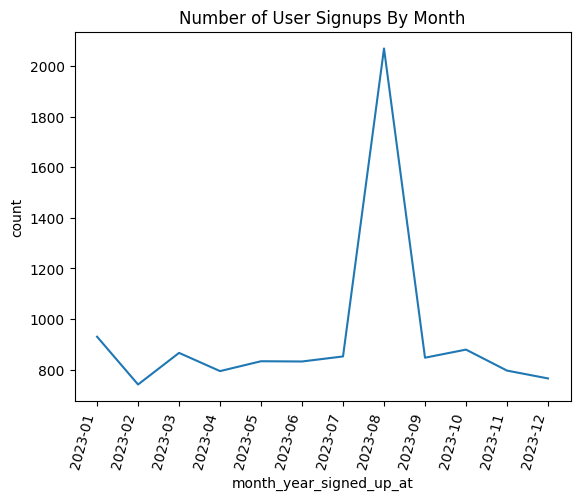

In [27]:
sns.lineplot(users["month_year_signed_up_at"].value_counts().sort_index())
plt.title("Number of User Signups By Month")
plt.xticks(rotation=75, ha="right");

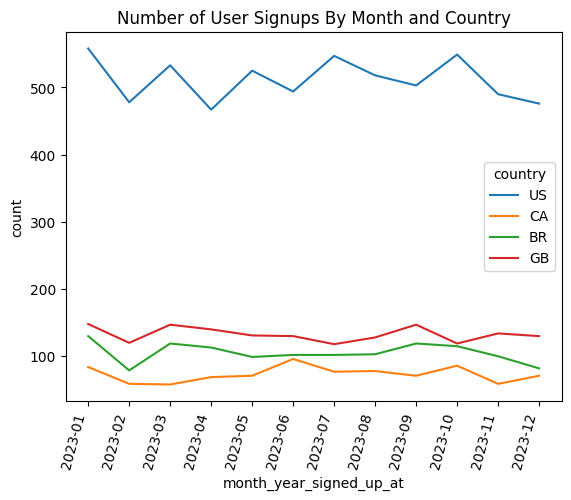

In [28]:
sns.lineplot(pd.DataFrame(users[["month_year_signed_up_at", "country"]].value_counts()).sort_values("month_year_signed_up_at"),
             x = "month_year_signed_up_at", y = "count", hue = "country")
plt.title("Number of User Signups By Month and Country")
plt.xticks(rotation=75, ha="right");

In [29]:
#@title Creating a data subset with only signups from August 2023 to investigate this spike

aug23 = users[users["month_year_signed_up_at"] == "2023-08"]

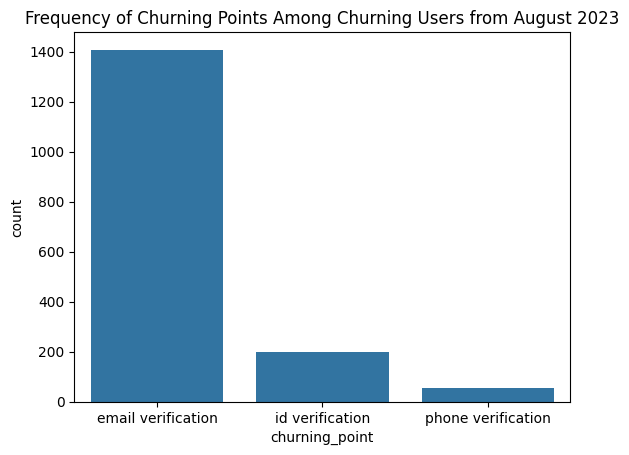

In [30]:
sns.barplot(aug23[~aug23["completed"]]["churning_point"].value_counts())
plt.title("Frequency of Churning Points Among Churning Users from August 2023");

### Analysis:
- August 2023 saw a huge increase in signups but also a corresponding decrease in the proportion of users who completed onboarding
- The majority of users from this influx churned at the email verification stage
- A likely cause of this influx was the price plummet of the crypto market that occured during August 2023 (see charts below)
- Hypothesis: most of these signups were people new to the crypto scene looking for an easy way to purchase Bitcoin while it was cheaper. However, many churned because Coinbase's verification process was much lengthier than they expected.

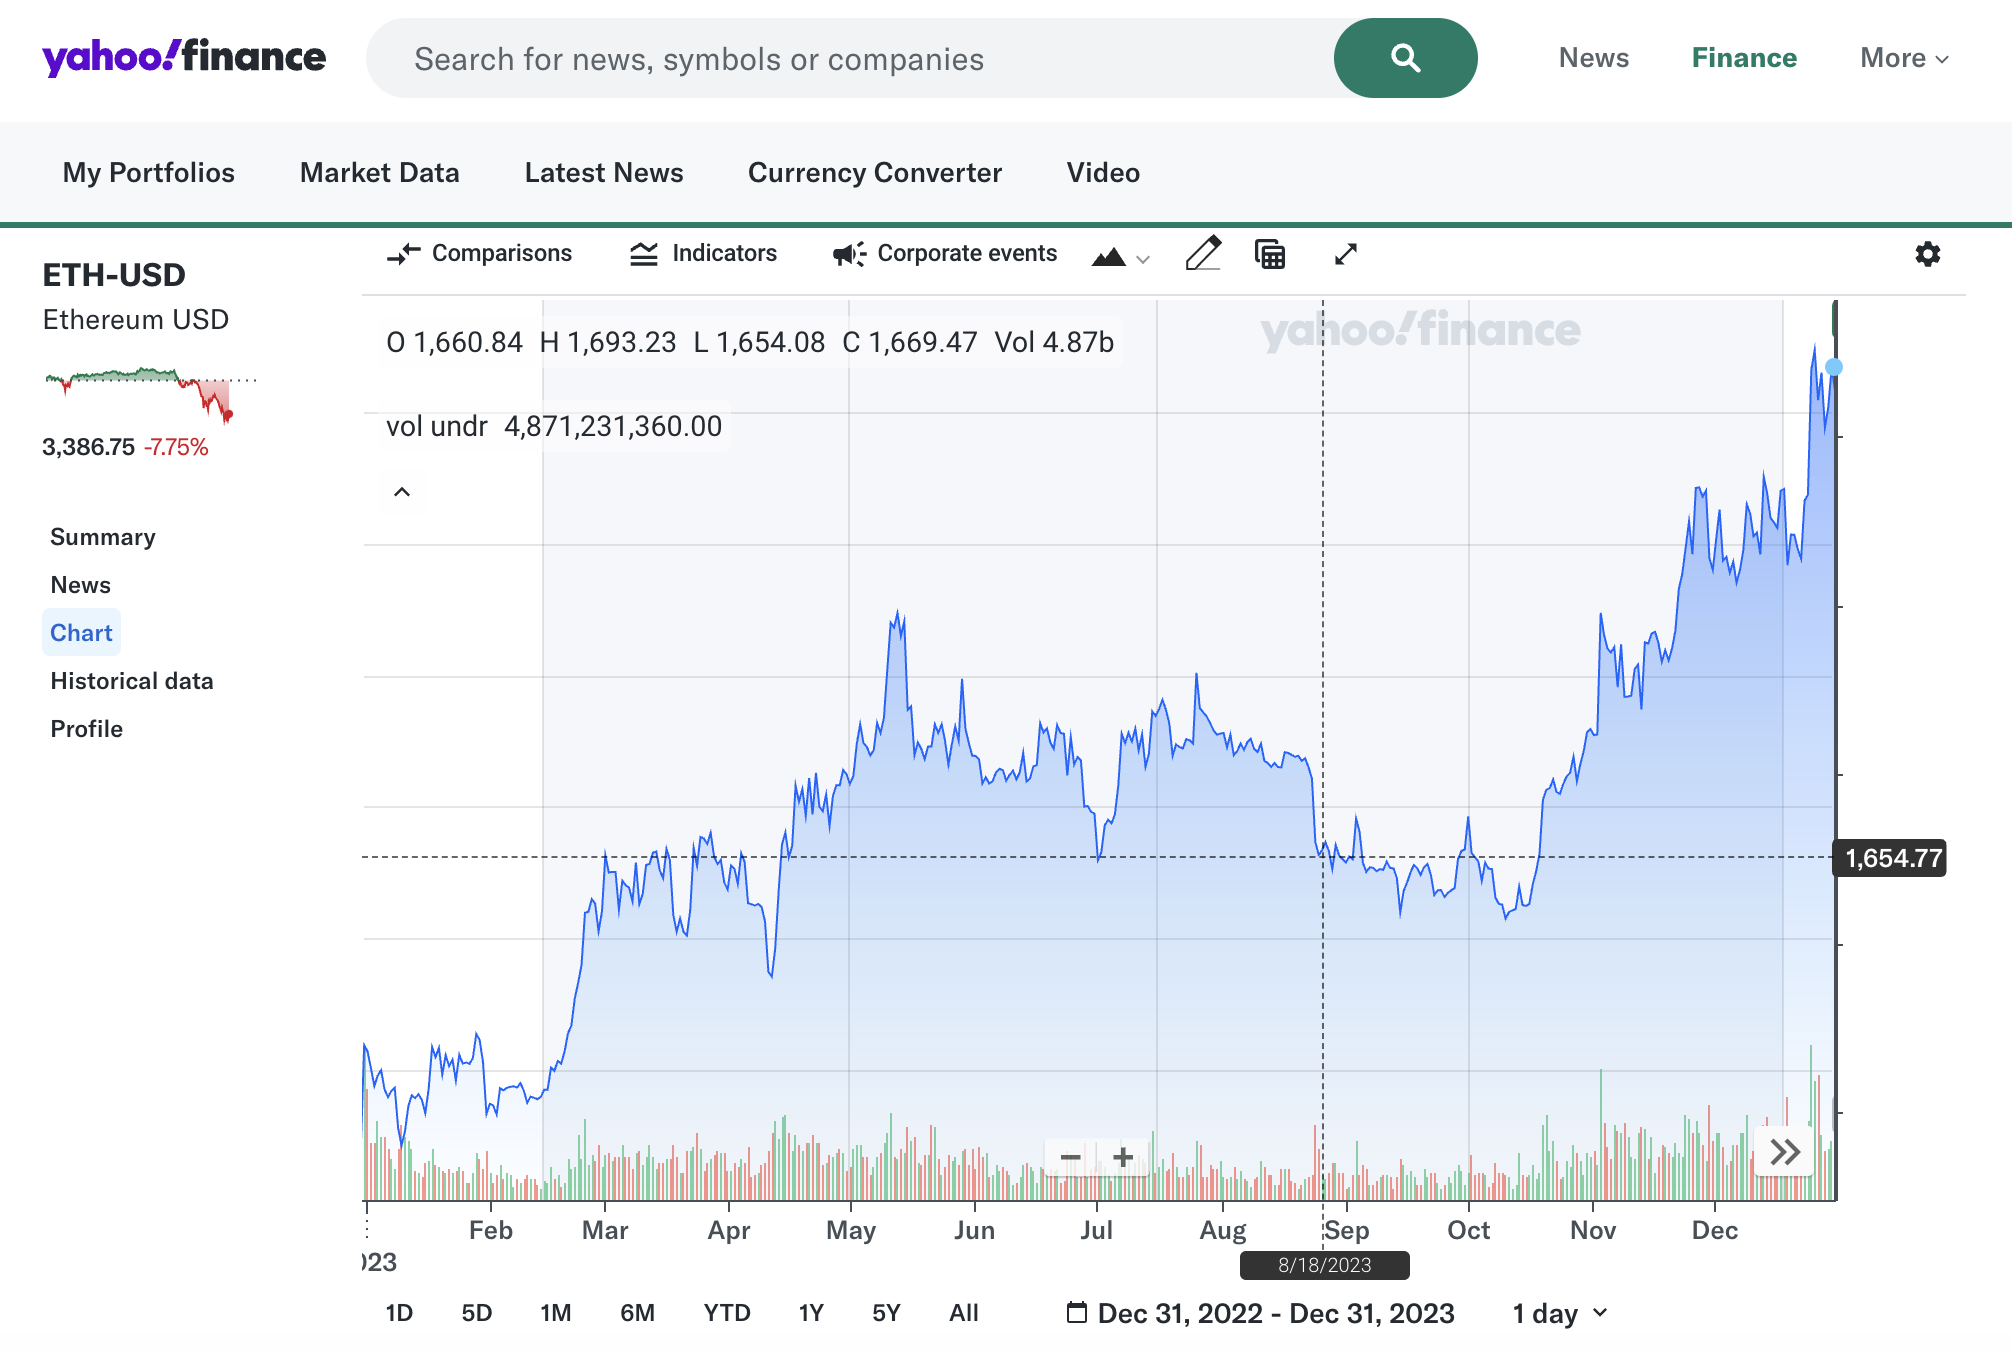

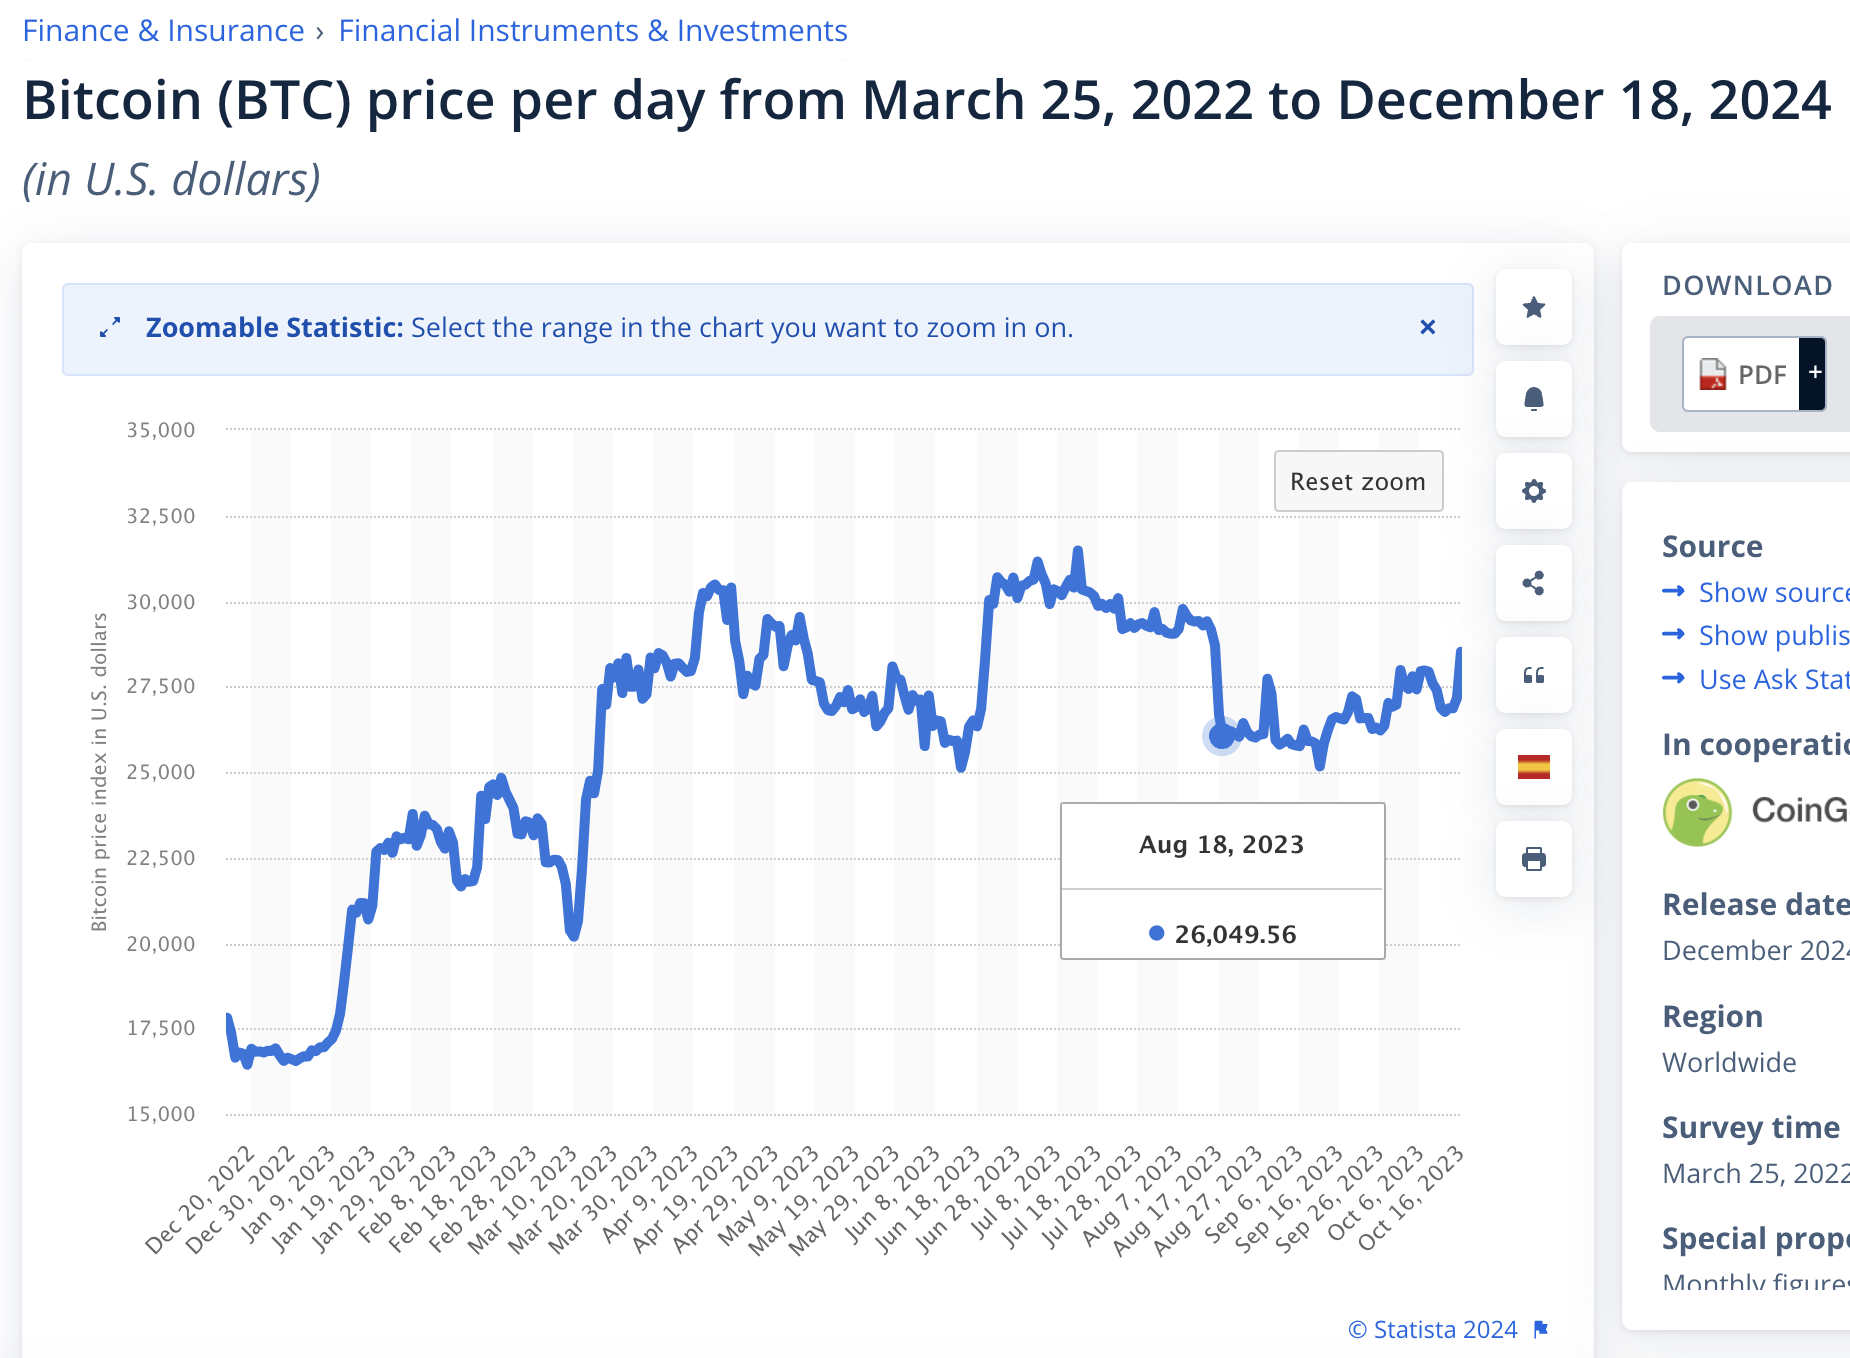

## Exploration 6: How does the length of time between signup and email / phone verification affect a user's likelihood to churn?

In [31]:
#@title Defining variables representing the difference between verification times and signup times

users["email_verif_signup_diff"] = (users["email_verified_at"] - users["signed_up_at"]).dt.total_seconds()
users["phone_verif_signup_diff"] = (users["phone_verified_at"] - users["signed_up_at"]).dt.total_seconds()
users["phone_email_verif_diff"] = (users["phone_verified_at"] - users["email_verified_at"]).dt.total_seconds()
users["id_verif_signup_diff"] = (users["phone_verified_at"] - users["email_verified_at"]).dt.total_seconds()

users

,user_id,country,platform,signed_up_at,phone_verified_at,email_verified_at,id_verified_at,churning_point,completed,hour_signed_up_at,dow_signed_up_at,month_year_signed_up_at,email_verif_signup_diff,phone_verif_signup_diff,phone_email_verif_diff,id_verif_signup_diff
0,0005dbc9,US,ios,2023-08-27 14:16:00,NaT,NaT,NaT,email verification,False,14.0,Sunday,2023-08,NaN,NaN,NaN,NaN
1,00080e40,US,android,2023-04-27 02:54:00,2023-04-27 02:58:41.103569,2023-04-27 02:55:05.560818,NaT,id verification,False,2.0,Thursday,2023-04,65.560818,281.103569,215.542751,215.542751
2,0009a830,CA,ios,2023-10-26 08:42:00,NaT,NaT,NaT,email verification,False,8.0,Thursday,2023-10,NaN,NaN,NaN,NaN
3,00179e0d,US,NaN,2023-08-02 10:20:00,NaT,NaT,NaT,email verification,False,10.0,Wednesday,2023-08,NaN,NaN,NaN,NaN
4,001d0f11,US,ios,2023-06-28 23:26:00,2023-06-28 23:31:15.530201,2023-06-28 23:27:44.335701,2023-06-29 17:39:34.863345,completed onboarding,True,23.0,Wednesday,2023-06,104.335701,315.530201,211.194500,211.194500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11227,ffe9b6e3,GB,ios,2023-06-22 06:12:00,NaT,NaT,NaT,email verification,False,6.0,Thursday,2023-06,NaN,NaN,NaN,NaN
11228,ffeccd22,GB,ios,2023-02-27 13:22:00,2023-02-27 13:27:02.936281,2023-02-27 13:25:20.506486,NaT,id verification,False,13.0,Monday,2023-02,200.506486,302.936281,102.429795,102.429795
11229,fff7063e,NaN,NaN,2023-08-15 11:42:00,NaT,NaT,NaT,email verification,False,11.0,Tuesday,2023-08,NaN,NaN,NaN,NaN
11230,fffc7b36,US,ios,2023-05-10 15:02:00,NaT,NaT,NaT,email verification,False,15.0,Wednesday,2023-05,NaN,NaN,NaN,NaN


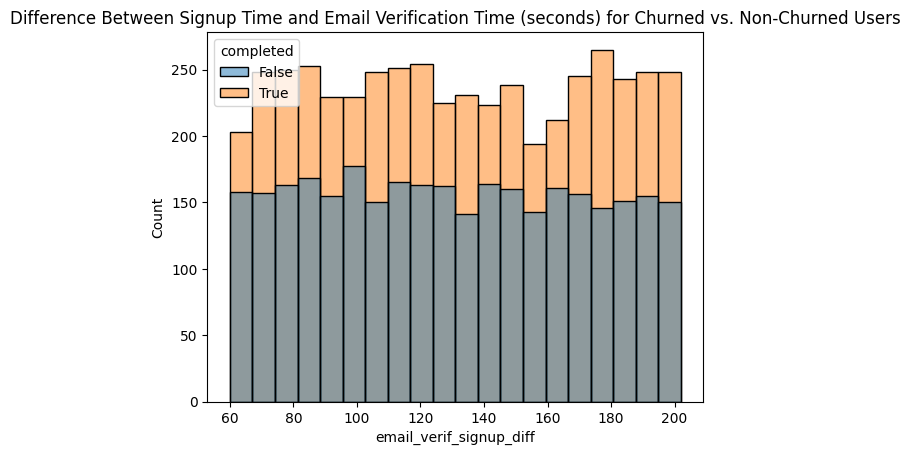

In [32]:
sns.histplot(users[~(users["email_verif_signup_diff"].isna())],
             x = "email_verif_signup_diff", hue = "completed")
plt.title("Difference Between Signup Time and Email Verification Time (seconds) for Churned vs. Non-Churned Users");

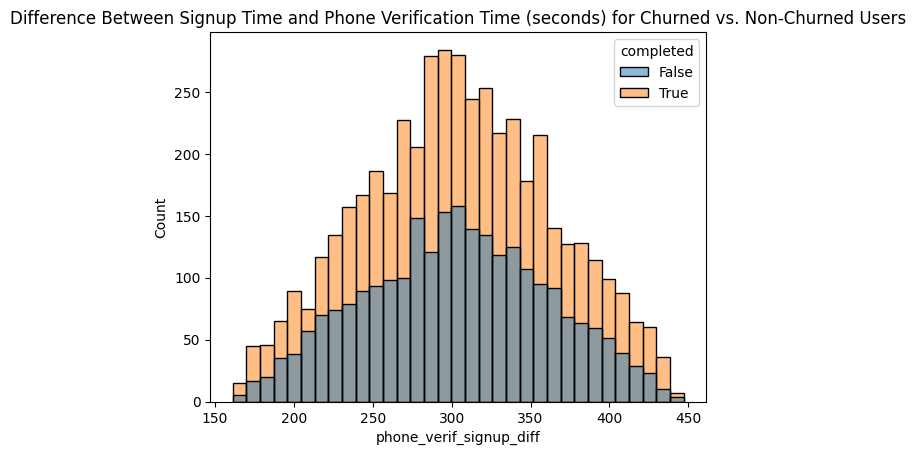

In [33]:
sns.histplot(users[~(users["phone_verif_signup_diff"].isna())],
             x = "phone_verif_signup_diff", hue = "completed")
plt.title("Difference Between Signup Time and Phone Verification Time (seconds) for Churned vs. Non-Churned Users");

### Based on these visualizations, it seems likely that there is no significant difference between the distributions of email verification time differences and phone verification time differences between churned vs. non-churned users. However, in the cells below, I perform an A/B test to verify this computationally:

In [34]:
churned_after_phone_verif = users[(~(users["phone_verif_signup_diff"].isna())) & users["completed"]]["phone_verif_signup_diff"]
completed_after_phone_verif = users[~(users["phone_verif_signup_diff"].isna()) & ~(users["completed"])]["phone_verif_signup_diff"]

t_test(churned_after_phone_verif, completed_after_phone_verif)

Fail to reject the null hypothesis: No significant difference.


0.4220457228626475

In [35]:
churned_after_email_verif = users[(~(users["email_verif_signup_diff"].isna())) & users["completed"]]["email_verif_signup_diff"]
completed_after_email_verif = users[~(users["email_verif_signup_diff"].isna()) & ~(users["completed"])]["email_verif_signup_diff"]

t_test(churned_after_email_verif, completed_after_email_verif)

Fail to reject the null hypothesis: No significant difference.


0.19369008317068506

### Analysis:
- Based on the results of these hypothesis tests, there appears to be no statistically significant difference between the distributions of email verification time differences and phone verification time differences between churned vs. non-churned users.
- This suggests that time delays in the email and phone verification steps of the onboarding process don't significantly increase a user's likelihood to churn.

## Exploration 7: Investigating high churning rates from Brazilian users

In [36]:
#@title Creating a subset of the data consisting only of users who churned

churned_data = id_user_verif[~id_user_verif["completed"]]

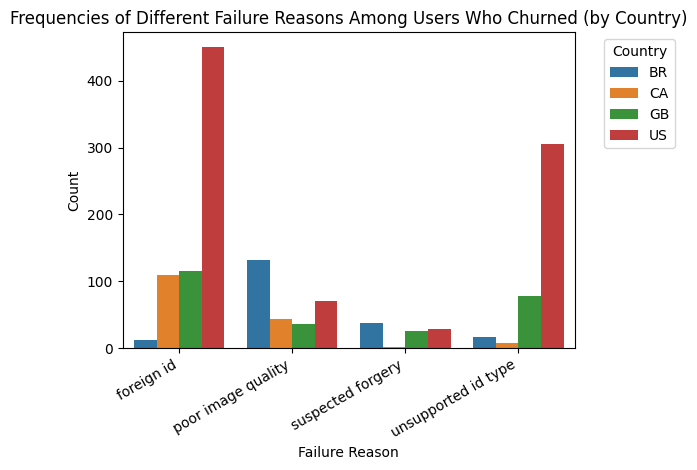

In [37]:
grouped_data = churned_data.groupby(["failure_reason", "country"]).size().reset_index(name="count")

sns.barplot(
    data=grouped_data,
    x="failure_reason",
    y="count",
    hue="country",
    ci=None
)

plt.title("Frequencies of Different Failure Reasons Among Users Who Churned (by Country)")
plt.xlabel("Failure Reason")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

### Because of the class imbalance between the number of users from each country, this chart isn't very informative. To account for this, I modified it to display the proportion of users from each country that experienced each failure reason:

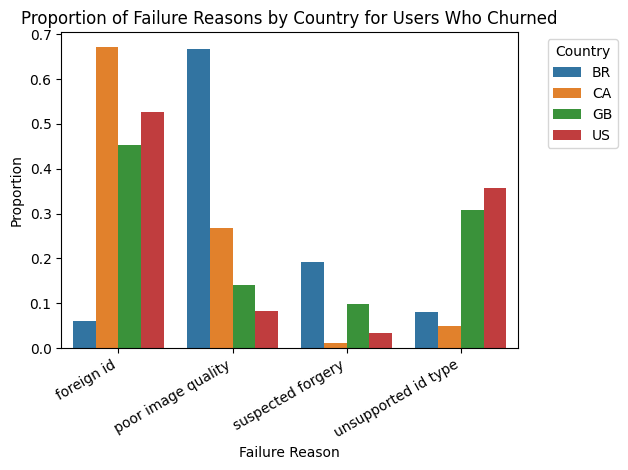

In [38]:
grouped_data = churned_data.groupby(["failure_reason", "country"]).size().reset_index(name="count")

total_per_country = churned_data.groupby("country").size().reset_index(name="total")

grouped_data = grouped_data.merge(total_per_country, on="country")

grouped_data["proportion"] = grouped_data["count"] / grouped_data["total"]

sns.barplot(
    data=grouped_data,
    x="failure_reason",
    y="proportion",
    hue="country",
    ci=None
)

plt.title("Proportion of Failure Reasons by Country for Users Who Churned")
plt.xlabel("Failure Reason")
plt.ylabel("Proportion")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

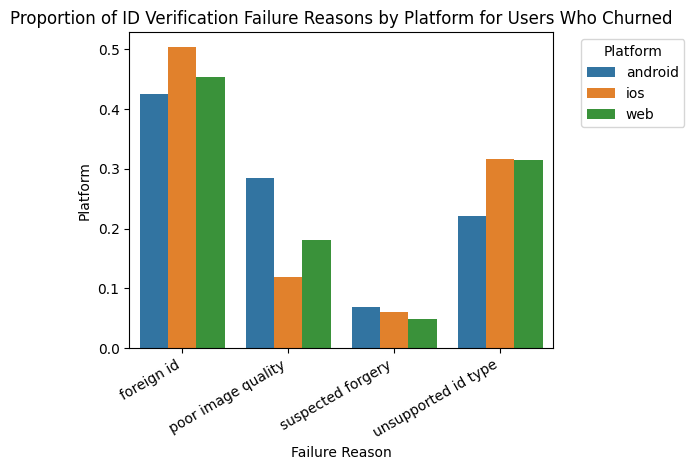

In [39]:
grouped_data = churned_data.groupby(["failure_reason", "platform"]).size().reset_index(name="count")

total_per_country = churned_data.groupby("platform").size().reset_index(name="total")

grouped_data = grouped_data.merge(total_per_country, on="platform")

grouped_data["proportion"] = grouped_data["count"] / grouped_data["total"]

sns.barplot(
    data=grouped_data,
    x="failure_reason",
    y="proportion",
    hue="platform",
    ci=None
)

plt.title("Proportion of ID Verification Failure Reasons by Platform for Users Who Churned")
plt.xlabel("Failure Reason")
plt.ylabel("Platform")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

### One thing stood out to me was the high proportion of both Brazilian users and android users who were failing ID verifications because of "poor image quality". In the cells below I investigate this further:

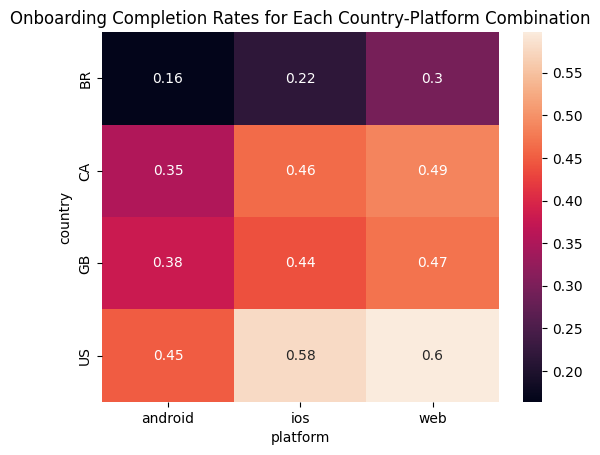

In [40]:
sns.heatmap(users.pivot_table(values = "completed", index = "country", columns = "platform", aggfunc = np.mean), annot = True)
plt.title("Onboarding Completion Rates for Each Country-Platform Combination");

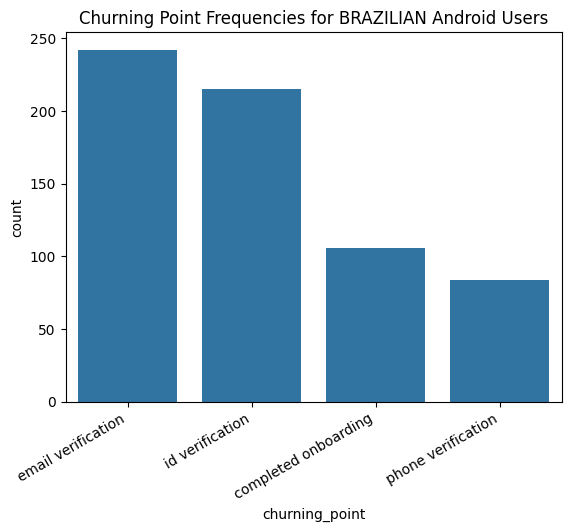

In [41]:
sns.barplot(users[(users["country"] == "BR") & (users["platform"] == "android")]["churning_point"].value_counts())
plt.title("Churning Point Frequencies for BRAZILIAN Android Users")
plt.xticks(rotation=30, ha="right");

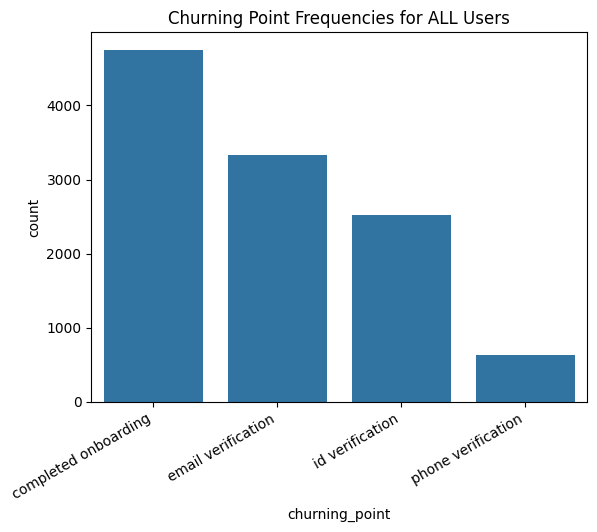

In [42]:
sns.barplot(users["churning_point"].value_counts())
plt.title("Churning Point Frequencies for ALL Users")
plt.xticks(rotation=30, ha="right");

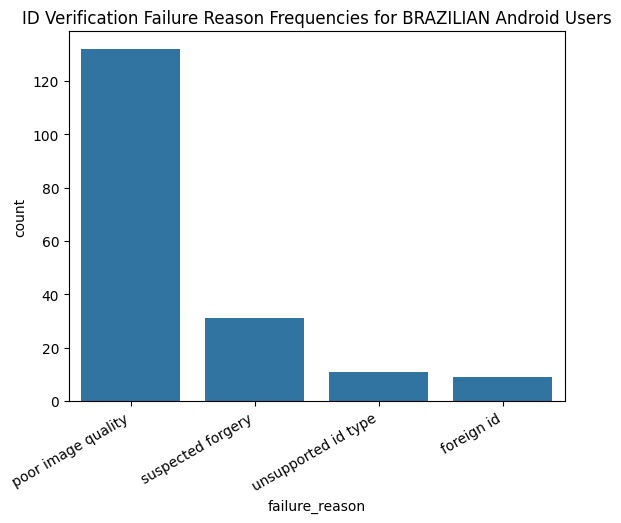

In [43]:
sns.barplot(id_user_verif[(id_user_verif["country"] == "BR") & (id_user_verif["platform"] == "android")]["failure_reason"].value_counts())
plt.title("ID Verification Failure Reason Frequencies for BRAZILIAN Android Users")
plt.xticks(rotation=30, ha="right");

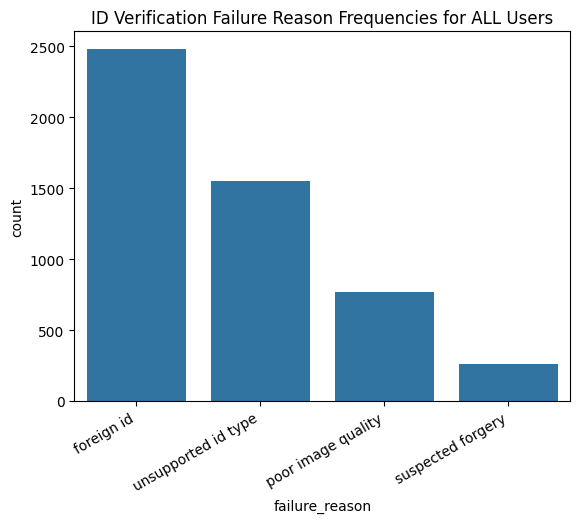

In [44]:
sns.barplot(id_user_verif["failure_reason"].value_counts())
plt.title("ID Verification Failure Reason Frequencies for ALL Users")
plt.xticks(rotation=30, ha="right");

### The distributions and results above suggest that relative to other user groups, Brazilian android users are churning at the ID verification stage more often, and are predominantly failing it due to "poor image quality". The below A/B tests attempt to establish related results compuationally:

In [45]:
#@title Is there a difference in the proportions of Brazilian Android and IOS Users Who Complete Onboarding?

br_android = users[(users["country"] == "BR") & (users["platform"] == "android")]["completed"]
br_non_android = users[(users["country"] == "BR") & (users["platform"] == "ios")]["completed"]

z_test(br_android, br_non_android)

Reject the null hypothesis: The groups are significantly different.


0.02137194844368246

In [46]:
#@title Is there a difference in the proportions of ALL Android and IOS Users Who Complete Onboarding?

android = users[(users["platform"] == "android")]["completed"]
non_android = users[(users["platform"] == "ios")]["completed"]

z_test(android, non_android)

Reject the null hypothesis: The groups are significantly different.


4.59798897417291e-41

### Analysis:
- Brazilian android users have the highest churning rate among all other subgroups, and a potential reason for this is their frequent failures of ID verification due to "poor image quality"
- Brazilian android users (and all android users in general) are less likely to complete onboarding than users on other platforms
- Potential explanation: android phones (especially the lower-end ones) tend to have worse cameras than Apple phones. This causes the photos that android users take of their IDs to be more frequently rejected due to "poor image quality", encouraging them to churn.

## Personal Experience, Summary, and Conclusions

### As part of my analysis, I actually went through the Coinbase onboarding process myself to gain a better understanding of it (see screenshots below). I will include some of my impressions in the conclusions section.

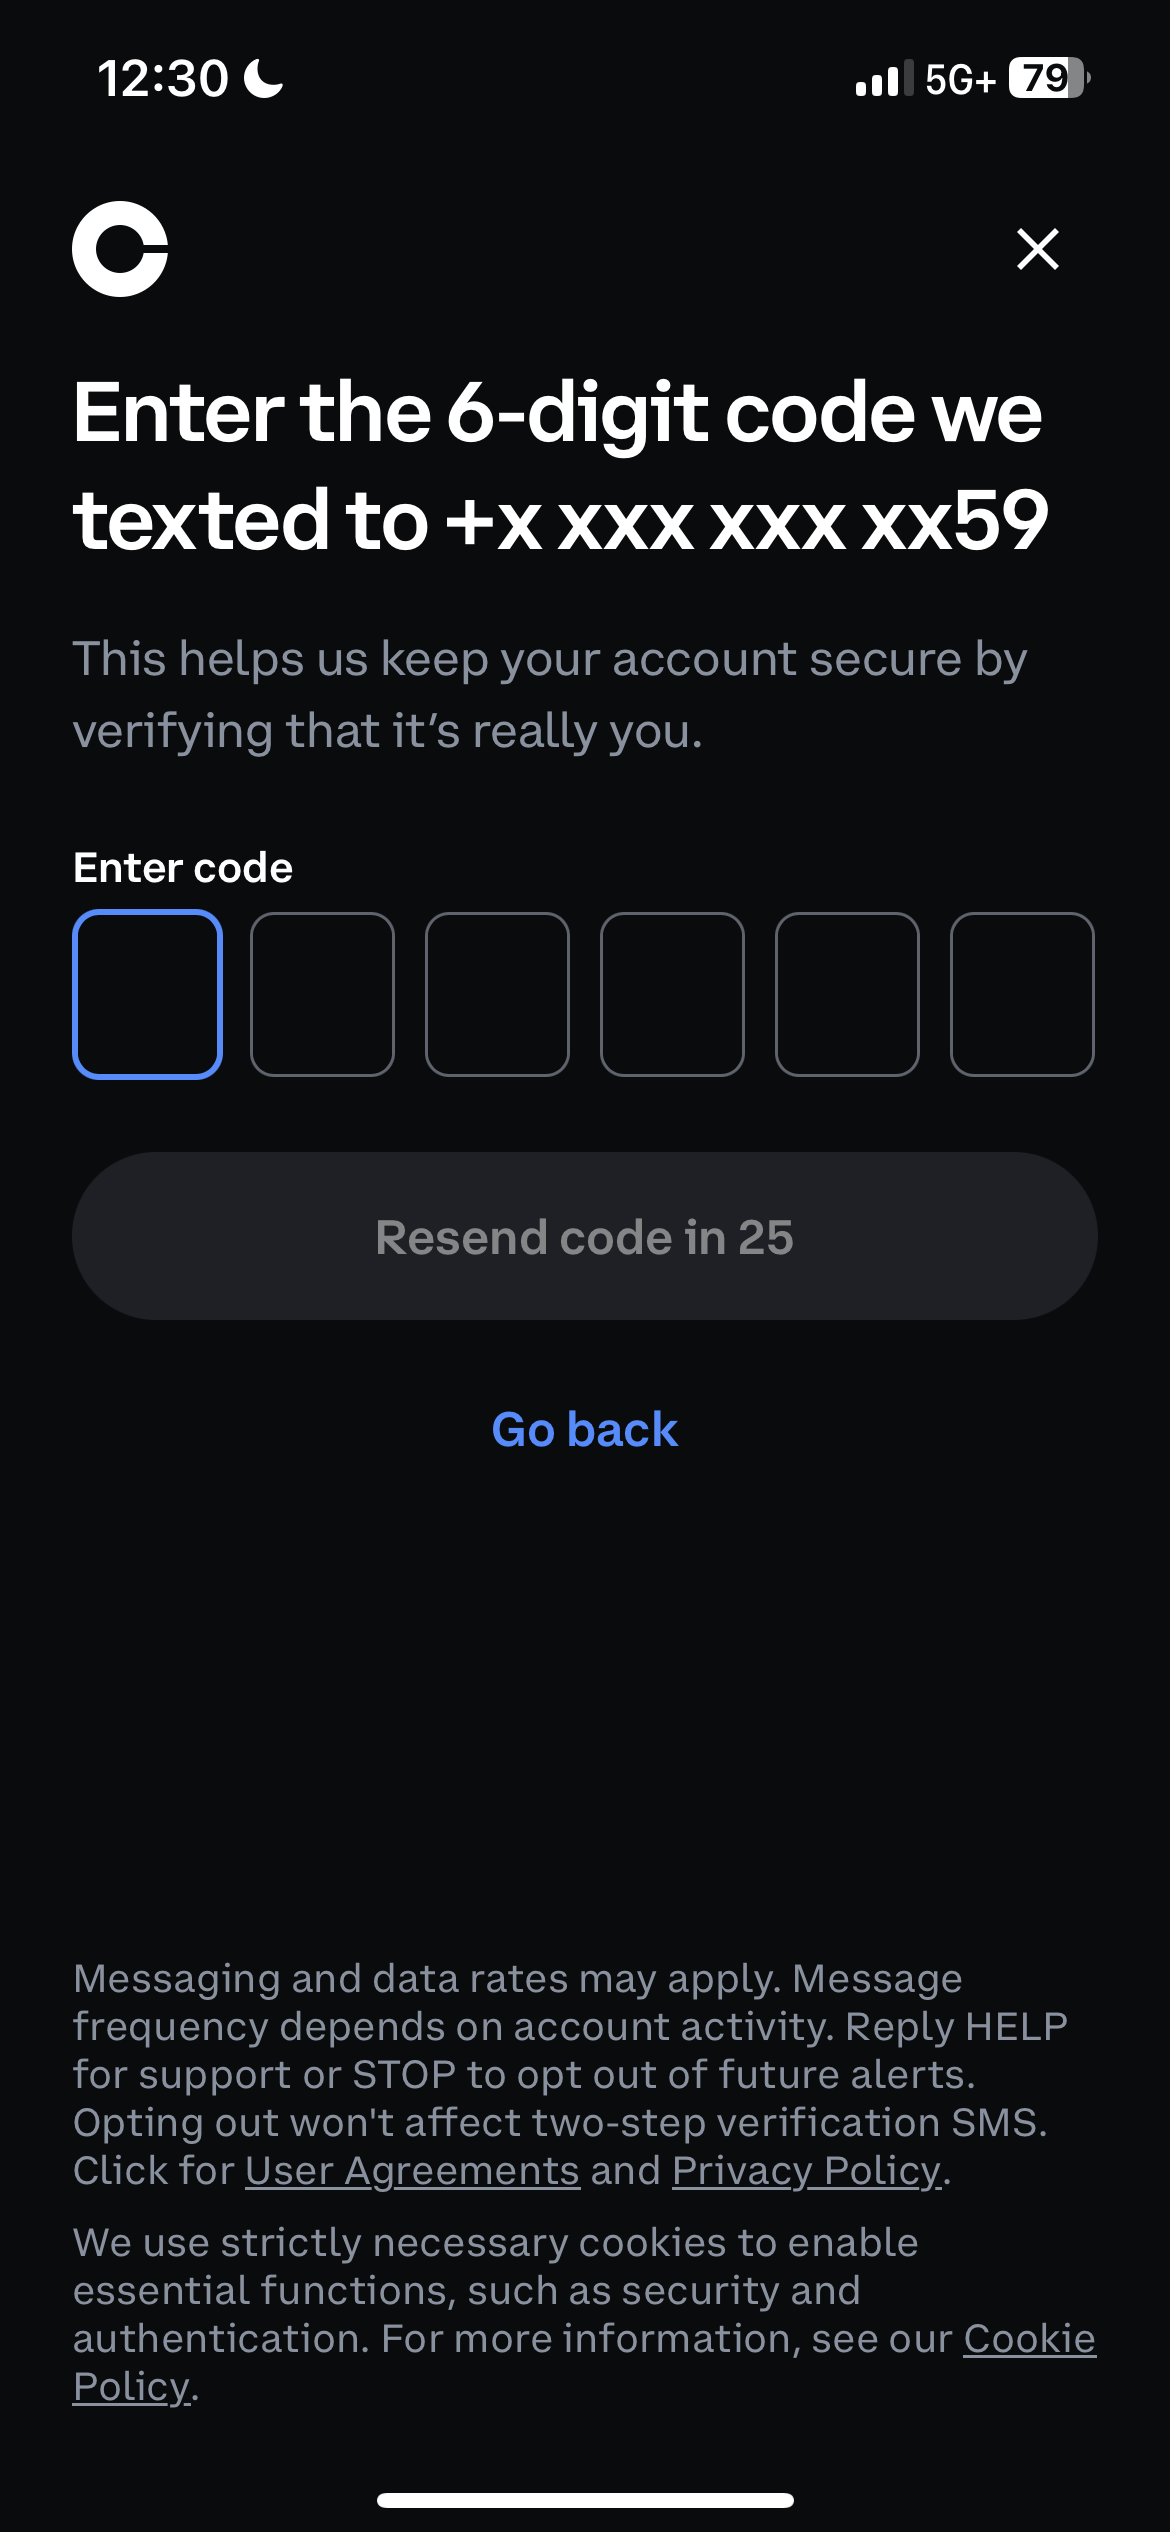

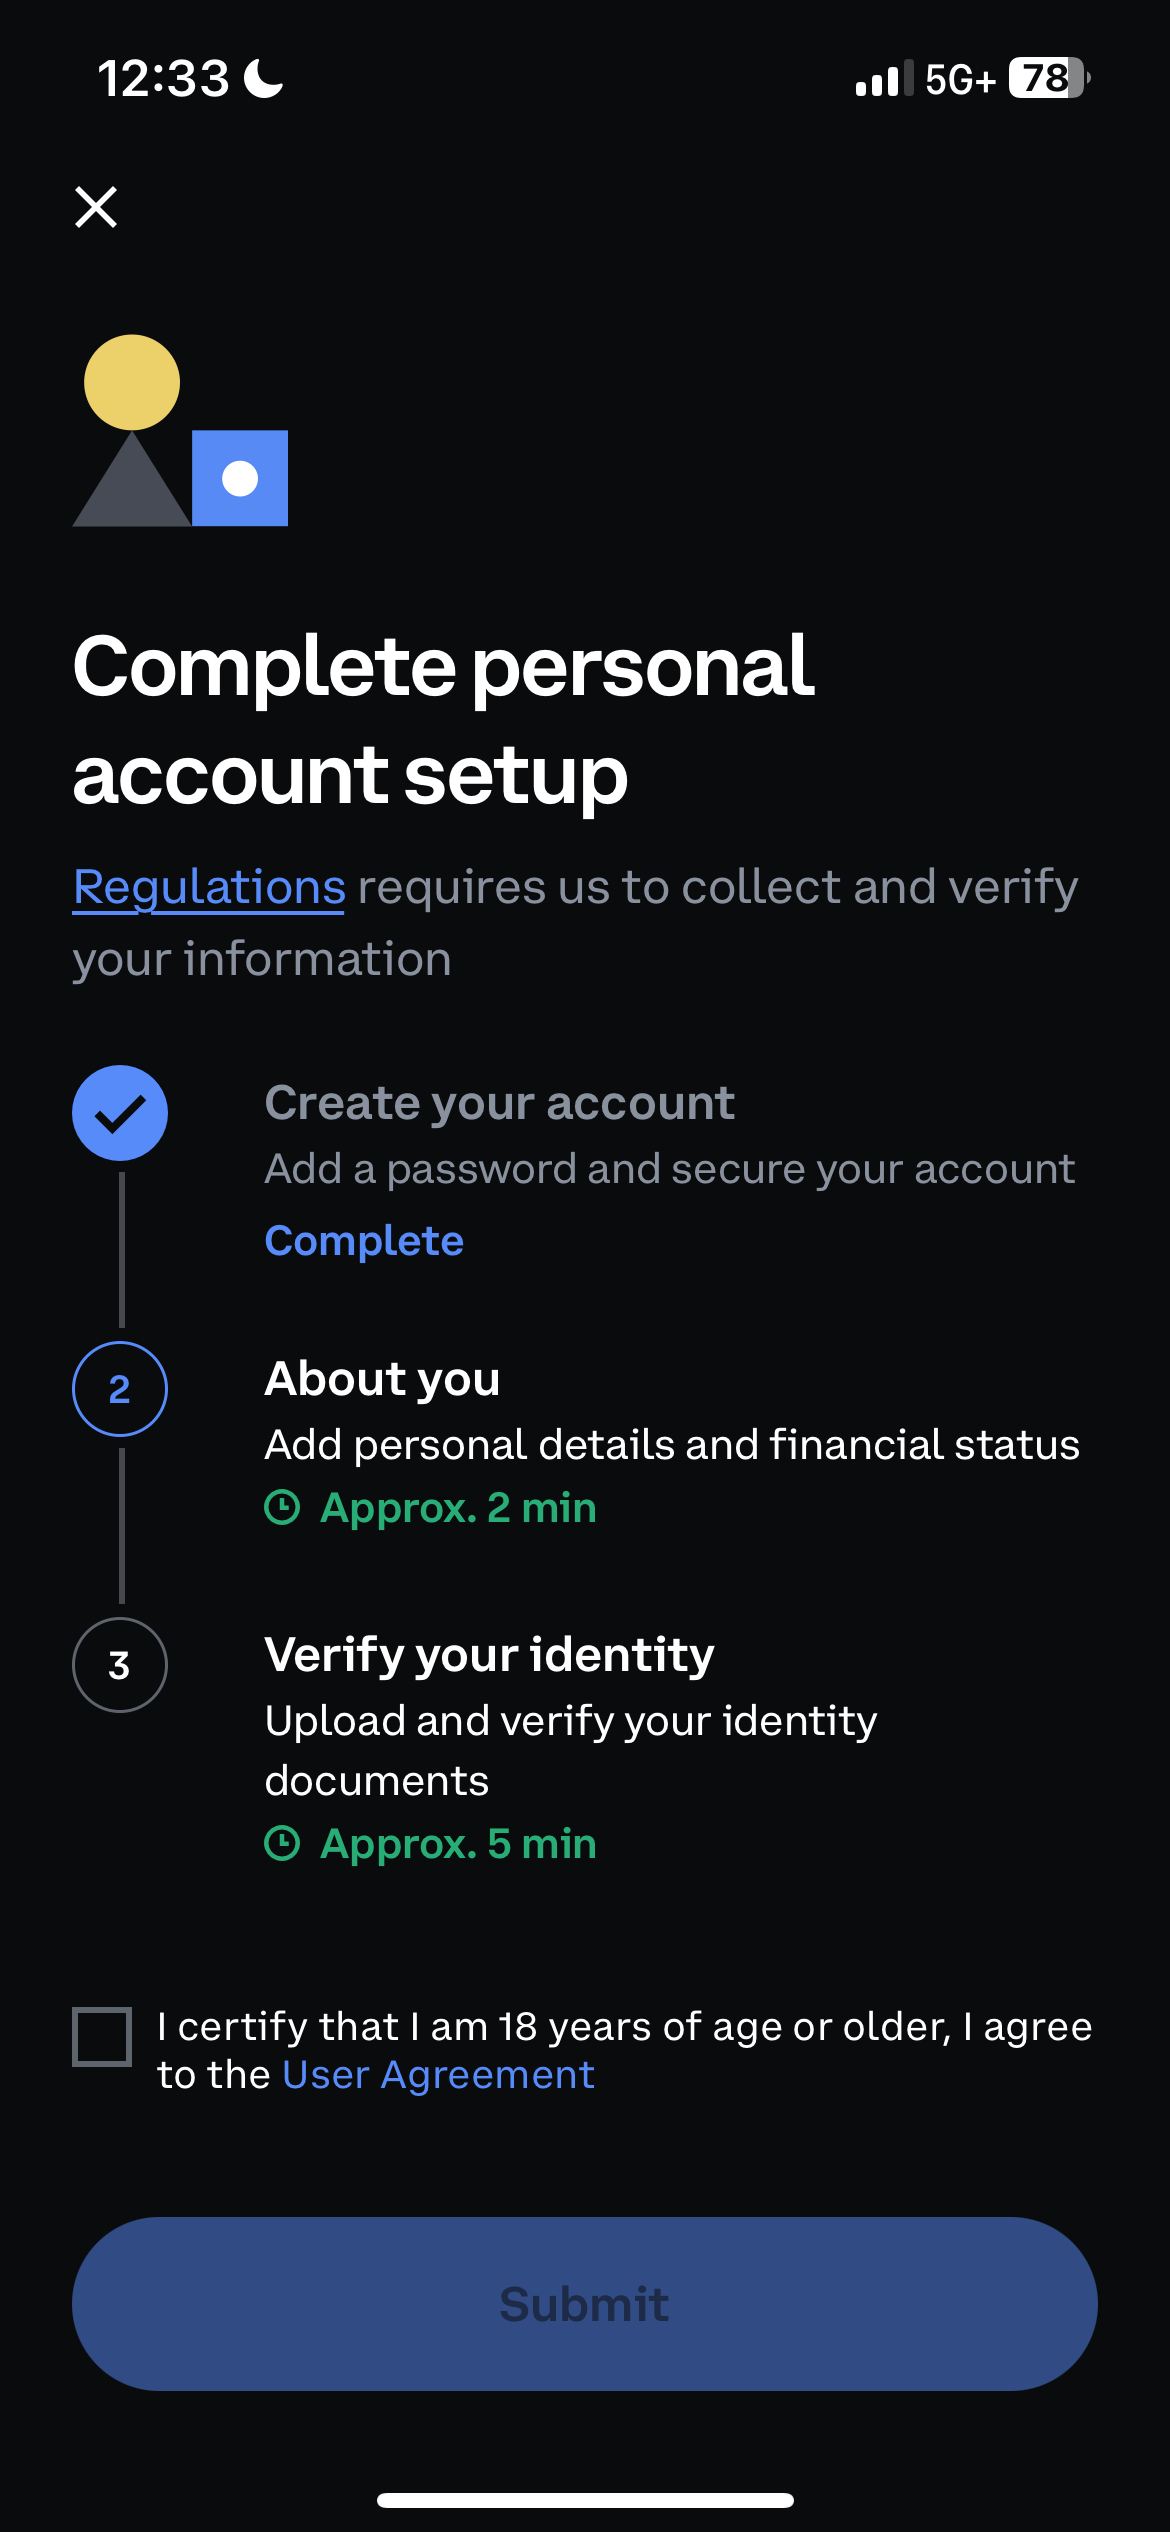

### Conclusions and Suggestions
- A large majority of users who churn do so at the email verification or ID verification stage, with few churning at the phone verification stage.
- In general, as users fail an increasing number of ID verifications, they are less likely to continue with the onboarding process. However, even after 6 failures, over 60% of users will see the onboarding process through to completion.
- Listing out all the steps in the process (as seen in the image above) is a good way to set customer's expectations for the onboarding. However, keeping a progress bar visible at each individual verification stage may also help mitigate churning (currently there is no progress bar on the phone verification screen as seen above). Specifically, it reminds users who have failed an ID verification that they are almost finished.
- There is no significant difference in the distribution of the total lengths of time spent in the email verification stage between churned and non-churned users. This suggests that lengthiness (in terms of time) is not a source of friction in the onboarding process.
- August 2023 saw a significant increase in signups, but a large majority of these new users churned during the email stage of verification process. This increase in users was correlated with a large price decrease of Bitcoin and Ethereum.
- To prevent new users from churning in times of volatility like August 2023, perhaps try to gamify the verification process or provide a small reward in BTC for completing it. Given that many of these new users will be new to the crypto scene, these extra incentives may be just enough to motivate them to complete the onboarding process that they might consider too lengthy.
- Brazilian android users have the highest churning rate by far, with only 16% completing the onboarding process. One driving factor behind this is that Brazilian android users are significantly more likely to fail the ID verification process for "poor image quality", possibly because their phone's camera quality is worse.
- To increase accessibility for this demographic, Coinbase could apply machine learning techniques (like Convolutional Neural Networks (CNNs), Variational Autoencoders (VAEs), or probabilistic reverse imaging techniques) to the images users upload in order to improve the quality and verify them more efficiently.